In [9]:
# !pip install roboflow
                

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="3j9KnCrn3vCKxbGLZmCp")
project = rf.workspace("medi-nxjbd").project("medicineboxes-nmmta")
version = project.version(2)
dataset = version.download("coco")

ModuleNotFoundError: No module named 'roboflow'

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/Users/baiporthn/Documents/MedicineBoxReg/code/exp


In [2]:
import os
import torchvision
import torch
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import random
import json
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
def convert_bbox_tocrop(box):
    """function convert bbox from annotation or prediction
    bbox format = [x_min, y_min, width, height] 
    crop area = [x_min, y_min, x_max, y_max]
    input box: list
    return crop_area: list
    """
    x_min = box[0]
    y_min = box[1]
    width = box[2]
    height = box[3]
    x_max = x_min + width
    y_max = y_min + height
    crop_area = [x_min, y_min, x_max, y_max]
    return crop_area
    


# Custom collate function for batching
def coco_collate_fn(batch):
    images, targets = zip(*batch)
    
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    return images, targets

# Randomly sample 20% of the dataset indices
def get_subset(dataset, percentage):
    total_size = len(dataset)
    subset_size = int(total_size * percentage)
    indices = random.sample(range(total_size), subset_size)
    return Subset(dataset, indices)



In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image

# Custom Dataset Class
class CocoClassificationDataset(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, img_height=32, img_width=100, train=True, transform=None):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoClassificationDataset, self).__init__(image_directory_path, annotation_file_path)
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform  # Store transform

    def __getitem__(self, idx):
        # Get image and annotations using the parent class
        image, annotations = super(CocoClassificationDataset, self).__getitem__(idx)

        # Crop image if bounding box exists
        if annotations and 'bbox' in annotations[0]:
            bbox = annotations[0]['bbox']
            crop_bbox = convert_bbox_tocrop(bbox)  # Custom bbox cropping function
            image = image.crop(crop_bbox)

        # Apply transformations (augmentation, resizing, etc.)
        if self.transform:
            image = self.transform(image)

        # Extract class label
        class_label = annotations[0]['category_id'] if annotations and 'category_id' in annotations[0] else -1
        target = torch.tensor(class_label, dtype=torch.long)

        return image, target

# Custom collate function for batching
def coco_collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.tensor(targets, dtype=torch.long)
    return images, targets





# dataset = os.path.join(HOME, 'MedicineBoxes-2')
dataset = '../MedicineBoxes-1'
# Settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")


# Define data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=5),
    transforms.RandomResizedCrop((32, 100), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


# Validation/Test transformations (NO augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((32, 100)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Load datasets
train_dataset = CocoClassificationDataset(TRAIN_DIRECTORY, transform=train_transform)
val_dataset = CocoClassificationDataset(VAL_DIRECTORY, transform=val_test_transform)
test_dataset = CocoClassificationDataset(TEST_DIRECTORY, transform=val_test_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=coco_collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=coco_collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=coco_collate_fn)
# Check dataset sizes
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of validation examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 2661
Number of validation examples: 157
Number of validation examples: 41


In [7]:
# Path to your annotation file
annotation_file = os.path.join(TRAIN_DIRECTORY, "_annotations.coco.json")

# Load the annotation file
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Create a mapping of category_id to category_name
category_id_to_name = {category['id']: category['name'] for category in coco_data['categories']}
name_to_category_id = {v: k for k, v in category_id_to_name.items()}

# Example: Print the mapping
print("Category Mapping:", category_id_to_name)

Category Mapping: {0: 'Boxes', 1: 'aferin', 2: 'aljil', 3: 'apodonorm5mg', 4: 'apodorm5mg', 5: 'apranax', 6: 'arveles', 7: 'aspirin', 8: 'betasalic', 9: 'box', 10: 'buprefarm5ug_hour', 11: 'dikloron', 12: 'dolcontin10mg', 13: 'dolcontin5mg', 14: 'dolorex', 15: 'fentanyl50ug_ml', 16: 'hametanKrem', 17: 'hametanMerhem', 18: 'ibucoldC', 19: 'imovane7-5mg', 20: 'levopidon25mg', 21: 'majezik', 22: 'majezikmajezik', 23: 'metadon_hydrochlorid40mg', 24: 'metpamid', 25: 'midazolam5mg_ml', 26: 'morfin10mg', 27: 'nexium', 28: 'nobligan_retard200mg', 29: 'oxycontin10mg', 30: 'oxycontin15mg', 31: 'oxycontin5mg', 32: 'oxynorm10mg', 33: 'parol', 34: 'silverdin', 35: 'sobril25mg', 36: 'terbisil', 37: 'travazol', 38: 'ultiva5mg', 39: 'unisom', 40: 'valium5mg', 41: 'xanor2mg'}


tensor([25, 32, 14, 39, 23, 28,  6, 33, 16,  7, 20, 16,  5,  9, 30, 32, 11, 11,
        32,  7, 31,  5, 14, 39, 17,  5, 41, 11, 17,  4,  1, 31, 32, 27, 36,  5,
        39,  1, 33, 12, 15, 29, 17, 14, 30, 36, 17, 17, 11, 32, 16, 16,  4,  6,
        40,  6, 21, 11,  9, 14,  3,  7, 28, 23])


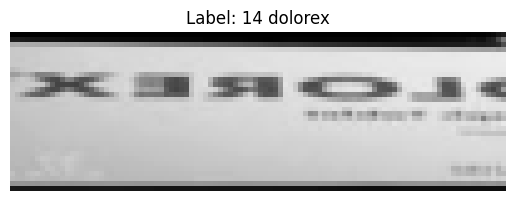

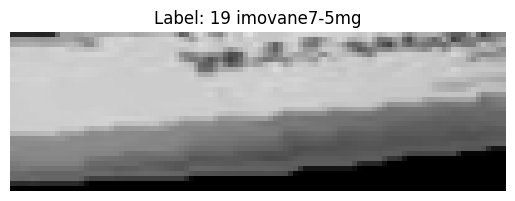

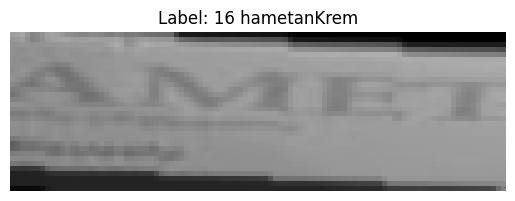

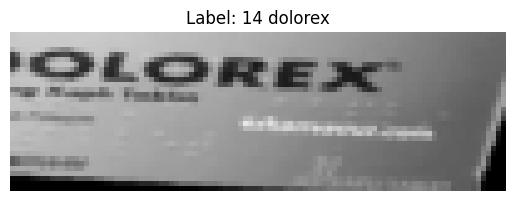

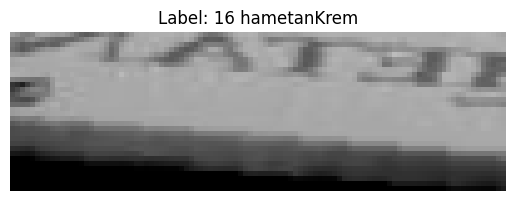

In [7]:

def show_image_with_label(image, label):
    """Display image with its readable label."""
    image = image.numpy().transpose((1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    image = (image + 1.0) / 2.0  # De-normalize from [-1, 1] to [0, 1]
    image = np.clip(image, 0, 1)  # Clip values to valid range
    plt.imshow(image)
    plt.title(f"Label: {label} {category_id_to_name.get(int(label))}")
    plt.axis("off")
    plt.show()
    
    
images, labels = next(iter(train_loader))
print(labels)
def display_batch(dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    
    for i in range(min(num_images, len(images))):
        show_image_with_label(images[i], labels[i])

display_batch(train_loader, num_images=5)

In [8]:
class_names = [category['name'] for category in coco_data['categories']]
dataset_sizes = len(train_dataset) + len(val_dataset) + len(test_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

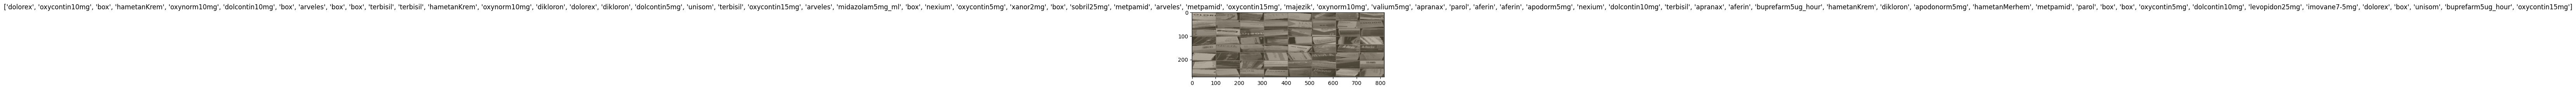

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
import time
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_loader=None, val_loader=None):
    since = time.time()

    # Initialize lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training phase
            model.train()  # Set model to training mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over training data
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Validation phase
            model.eval()  # Set model to evaluate mode
            val_loss = 0.0
            val_corrects = 0

            with torch.no_grad():  # No gradients needed during validation
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Statistics
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)

            # Update learning rate scheduler
            scheduler.step()

            # Calculate losses and accuracies
            train_loss = running_loss / len(train_loader.dataset)
            train_acc = running_corrects.double() / len(train_loader.dataset)

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_corrects.double() / len(val_loader.dataset)

            # Append the values for plotting
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            # Print the results
            print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

            # Deep copy the model if we have a new best validation accuracy
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)

            print()

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

    # Return losses and accuracies to plot
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [11]:
# Example: when plotting an image from a tensor
def imshow(tensor, title=None):
    """Display image for Tensor."""
    tensor = tensor.cpu().numpy().transpose((1, 2, 0))  # Move tensor to CPU and convert to NumPy
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    plt.imshow(tensor)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# In the plotting function for loss and accuracy:
def plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    num_epochs = len(train_losses)

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(num_epochs), val_accuracies, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()


In [12]:
def visualize_model(model, num_images=6, val_loader=val_loader, class_names=class_names, device='cpu'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')

                # Call imshow to display the image
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [13]:
## Load pre-trained IMAGENET1K_V1 reset final fully connected layer.

In [27]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Modify the fully connected (fc) layer to add Dropout
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Increase dropout to stabilize validation
    nn.Linear(num_ftrs, 256),  
    nn.ReLU(),
    nn.Linear(256, 42)  # Output layer
)

model_ft = model_ft.to(device)



criterion = nn.CrossEntropyLoss(label_smoothing=0.05)


# Optimizer: Slightly higher weight decay for regularization
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0003, weight_decay=4e-4)

# Learning Rate Scheduler: Increase T_max to smooth learning
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=170)


In [28]:
### Train the model
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)



Epoch 0/99
----------
Train Loss: 3.4567 Train Acc: 0.1237
Val Loss: 3.4478 Val Acc: 0.1598

Epoch 1/99
----------
Train Loss: 2.7530 Train Acc: 0.3329
Val Loss: 3.3171 Val Acc: 0.2320

Epoch 2/99
----------
Train Loss: 2.1958 Train Acc: 0.5092
Val Loss: 2.9485 Val Acc: 0.3299

Epoch 3/99
----------
Train Loss: 1.8707 Train Acc: 0.5829
Val Loss: 2.6909 Val Acc: 0.4072

Epoch 4/99
----------
Train Loss: 1.6854 Train Acc: 0.6066
Val Loss: 2.2659 Val Acc: 0.4227

Epoch 5/99
----------
Train Loss: 1.5237 Train Acc: 0.6724
Val Loss: 2.1738 Val Acc: 0.4536

Epoch 6/99
----------
Train Loss: 1.3479 Train Acc: 0.7013
Val Loss: 1.9302 Val Acc: 0.5258

Epoch 7/99
----------
Train Loss: 1.1382 Train Acc: 0.7711
Val Loss: 1.7645 Val Acc: 0.5619

Epoch 8/99
----------
Train Loss: 1.0699 Train Acc: 0.7921
Val Loss: 1.7846 Val Acc: 0.5412

Epoch 9/99
----------
Train Loss: 0.9879 Train Acc: 0.8132
Val Loss: 1.9983 Val Acc: 0.4794

Epoch 10/99
----------
Train Loss: 0.9285 Train Acc: 0.8408
Val Loss: 

In [29]:
train_acc = np.array([t.cpu().numpy() for t in train_acc])
val_acc = np.array([t.cpu().numpy() for t in val_acc])

Mean Train Accuracy: 0.9222368421052631
Mean Val Accuracy: 0.6731443298969073
Mean Train Loss: 0.6470490291118622
Mean Val Loss: 1.5622457156476284


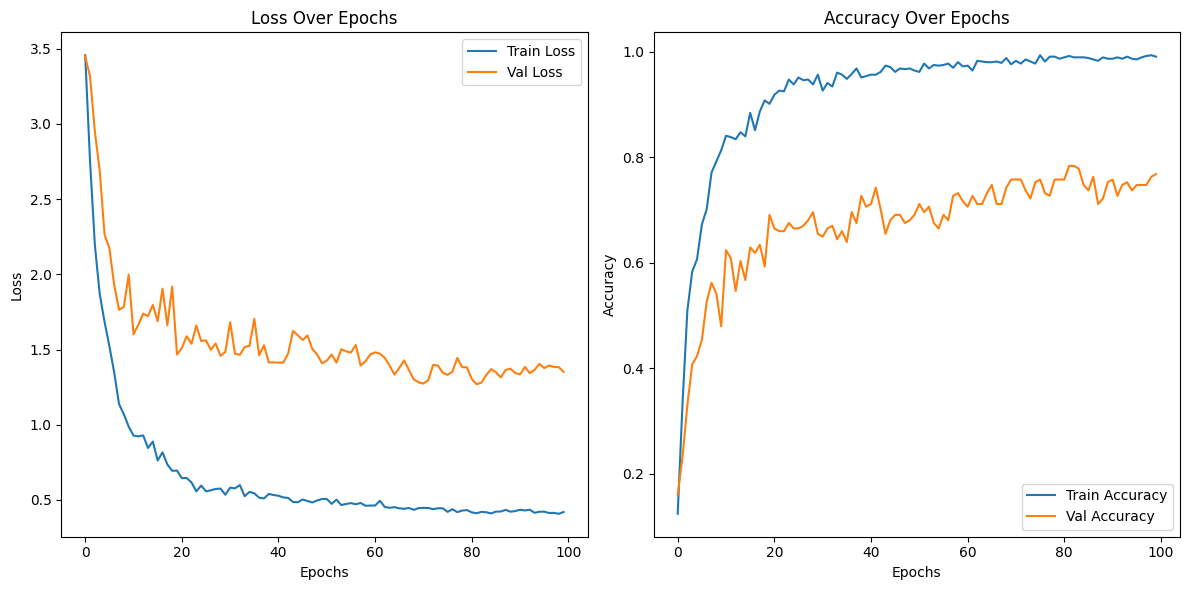

In [30]:
# Plot the learning curves



print(f"Mean Train Accuracy: {np.mean(train_acc)}")
print(f"Mean Val Accuracy: {np.mean(val_acc)}")
print(f"Mean Train Loss: {np.mean(train_loss)}")
print(f"Mean Val Loss: {np.mean(val_loss)}")


plot_learning_curves(train_loss, train_acc, val_loss, val_acc)
